# Text Representation

In [10]:
import pandas as pd

In [11]:
# Fetch preprocessed data
model_data = pd.read_csv("data/keywords.csv")
model_data.head()

,Id,Name,Language,keywords
0,1020396,the gospel of john,eng,francis_j._moloney michael_glazier gospel nar...
1,1073868,hanslick on the musically beautiful: sixteen l...,eng,geoffrey_payzant 1-877275-49-2 musikalischsch...
2,1038843,never tell your name,eng,josie_levy_martin 1st_book_library nun memoir...
3,1021643,the reign of law,eng,james_lane_allen 1st_world_library nursery ro...
4,1019884,cousin phillis,eng,elizabeth_gaskell 1st_world_library railway f...


In [12]:
model_data.shape

(29396, 4)

---
### Vectorize the keywords summary using TF-IDF
- Convert the keywords for each book into a numeric vector, based on the frequency of each word in the book's keywords
- Keep token pattern such that tokens with underscore are not ignored.
- Remove tokens occuring less than 3 times or occur in more than 60% of the documents (common tokens).
- Remove english language stop words

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word',
                        min_df=3,
                        max_df = 0.6,
                        stop_words="english",
                        encoding = 'utf-8', 
                        token_pattern=r"(?u)\S\S+")
tfidf_encoding = tfidf.fit_transform(model_data["keywords"])

In [14]:
tfidf_encoding.toarray().shape

(29396, 12879)

---
### Visualize the TF-IDF word embeddings

d:\A\BookRecommendationSys\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


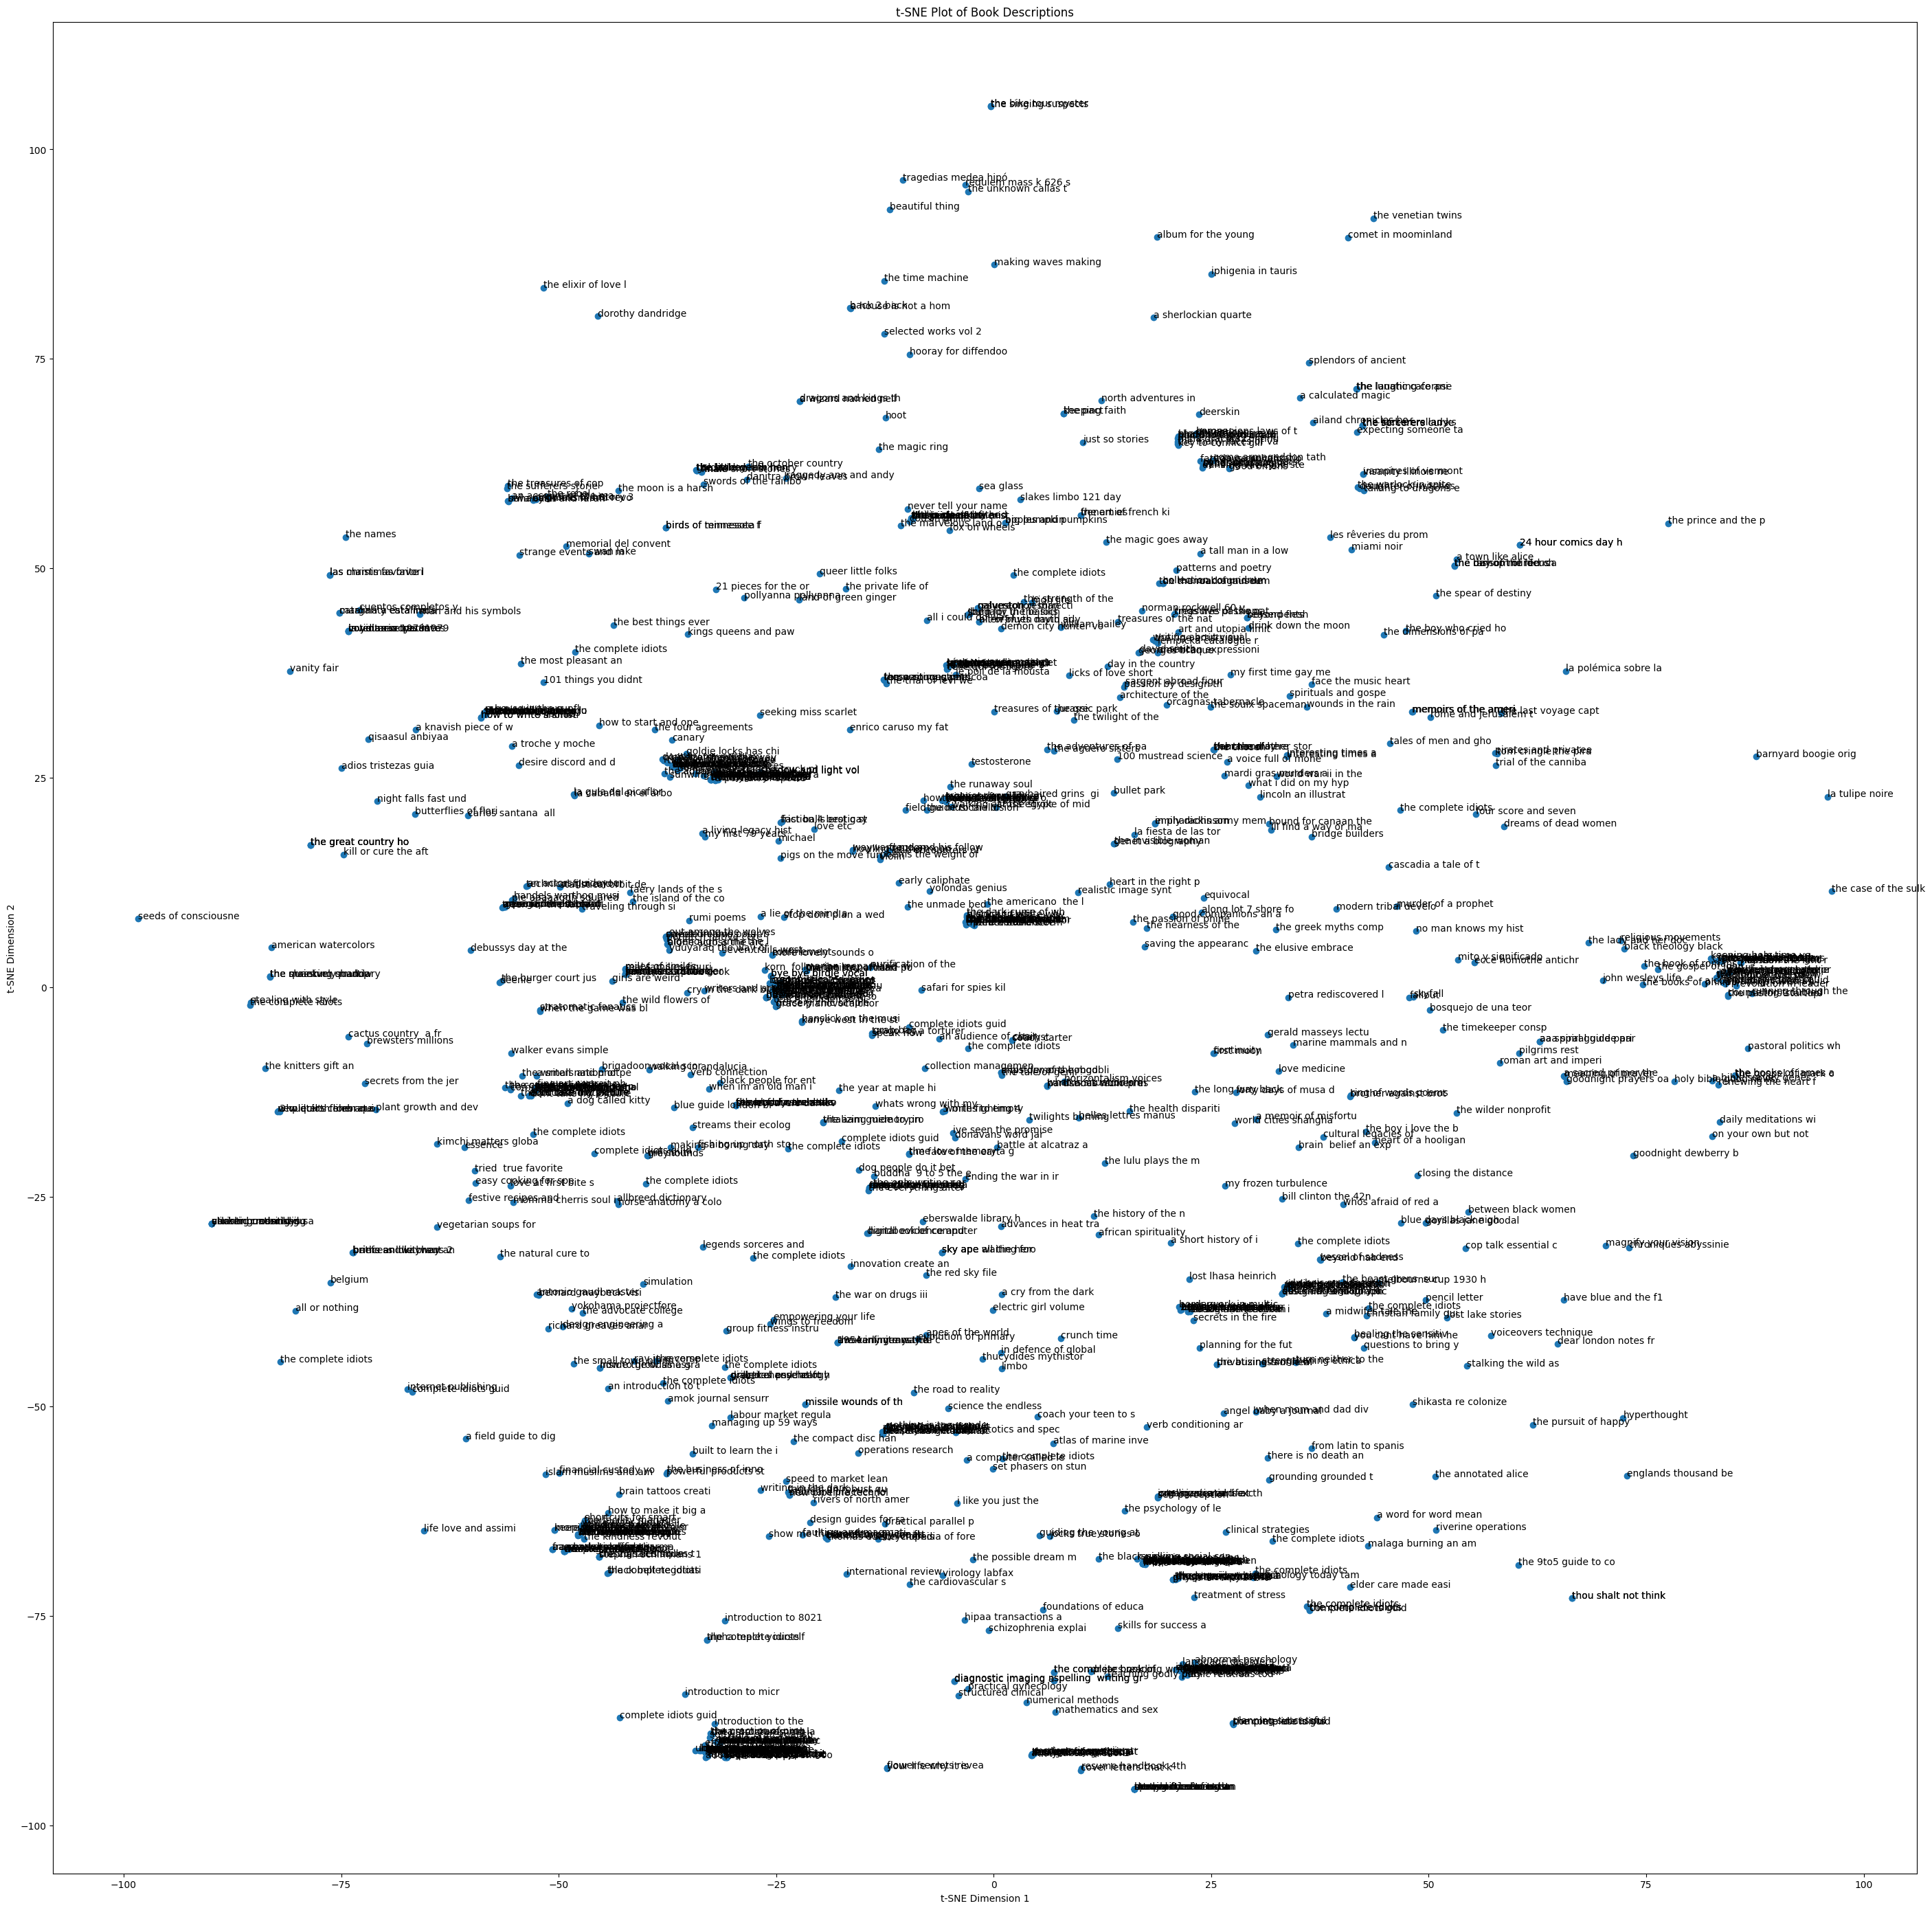

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re

# Clean book names
model_data['Name'] = model_data['Name'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2,learning_rate='auto', random_state=42)
tsne_results = tsne.fit_transform(tfidf_encoding)

# Plot
plt.figure(figsize=(35, 35))
plt.scatter(tsne_results[:1000, 0], tsne_results[:1000, 1])

# Annotate points with book names
for i, txt in enumerate(model_data['Name'][:1000]):
    plt.annotate(txt[:20], (tsne_results[i, 0], tsne_results[i, 1]))


plt.title('t-SNE Plot of Book Descriptions')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

---
### Cosine Similarity between books vector representation

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_encoding, tfidf_encoding)
print(cosine_sim)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [16]:
cosine_sim.shape

(29396, 29396)

In [17]:
indices = pd.Series(model_data['Name'])
indices[:5]

0                                   the gospel of john
1    hanslick on the musically beautiful: sixteen l...
2                                 never tell your name
3                                     the reign of law
4                                       cousin phillis
Name: Name, dtype: object

#### Save sparse matrix to use it for prediction 
#### as its long dimension slows down the prediction process

In [18]:
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz

# Convert your cosine_sim to a sparse matrix
cosine_sim_sparse = csr_matrix(cosine_sim)

# Save the sparse matrix
save_npz("cosine_sim_sparse2.npz", cosine_sim_sparse)

---
### Recommendation
- Given a book name, find top n similar books based on cosine similarity score.
1) Series Information
2) Other Books In Numbered Series
3) Theme
4) Author

In [40]:
# new recommend
import pandas as pd
import numpy as np


def recommend(title, n = 5, cosine_sim_file="cosine_sim_sparse2.npz", indices=indices, model_data=model_data):
    # Load the sparse matrix
    cosine_sim_sparse = load_npz(cosine_sim_file)
    
    #if given a title not in database
    if title not in indices.values:
        #split the given title and search with pieces in db until you find a match
        ls = title.split(' ')
        m = len(ls)
        search = [' '.join(ls[:i]) for i in range(m, 0, -1)] 
        for s in search:
            newtitle = model_data.loc[model_data['Name'].str.lower().str.contains(s)][0:1]['Name']
            if len(newtitle) != 0:
                break
        else:
            return "Book not found"
        title = newtitle.values[0]

    recommended_books = []
    idx = indices[indices == title].index[0]

    # Use sparse matrix multiplication to compute cosine similarities efficiently
    sim_scores = cosine_sim_sparse[idx].toarray().flatten()

    # Get indices of top similar books
    top_indices = sim_scores.argsort()[::-1][1:n+1]

    for i in top_indices:
        recommended_books.append(list(model_data['Name'])[i])

    return recommended_books

# Example usage
recommendations = recommend('harry potter and the chamber of secrets', 10)
recommendations

['j. k. rowling: new and revised: the wizard behind harry potter',
 'the making of the potterverse: a month-by-month look at harry’s first 10 years',
 'fantastic beasts and where to find them',
 'wise secrets of aloha: learn and live the sacred art of lomilomi',
 'airfare secrets exposed: how to find the lowest fares available anywhere!',
 'babel tower (the frederica quartet, #3)',
 "narratives of love and loss: studies in modern children's fiction",
 'the mystery of harry potter: a catholic family guide',
 'creator',
 'pulmonary/respiratory therapy secrets: with student consult online access']

In [41]:
# Recommendations with series information
print("\033[1m{}\033[0m".format("Recommendation (Series Information) based on the read: The Eastland Disaster (Images of America: Illinois)"))
display(recommend("a bit on the side", 5))

# Recommendations with series information numbered
print("\n\033[1m{}\033[0m".format("Recommendation (Numbered Series) based on the read: The Majolica Murders (Antique Lover, #5)"))
display(recommend("the majolica murders (antique lover, #5)", 5))

print("\n\033[1m{}\033[0m".format("Recommendation (Theme: Programming) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)"))
display(recommend('the practice of programming (addison-wesley professional computing series)', 5))

print("\n\033[1m{}\033[0m".format("Recommendation (Author: Dean Koontz) based on the read: Cold Fire"))
display(recommend("cold fire dean koontz",5))

Recommendation (Series Information) based on the read: The Eastland Disaster (Images of America: Illinois)


['the hill bachelors',
 'meteor in the madhouse',
 'the disenchantments of love',
 'when the green woods laugh (the pop larkin chronicles #3)',
 'the novellas of hortense calisher (modern library)']


Recommendation (Numbered Series) based on the read: The Majolica Murders (Antique Lover, #5)


['four on the floor (antique lover, #4)',
 'caught dead',
 'the weedless widow (antique lover, #2)',
 'the marriage casket (antique lover, #3)',
 'how to build outdoor structures']


Recommendation (Theme: Programming) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)


['unix for the mainframer: the essential reference for commands, conversions, tcp/ip',
 'smalltalk with style',
 'the c++ programming language',
 'sams teach yourself beginning programming in 24 hours',
 'data structures & other objects using java']


Recommendation (Author: Dean Koontz) based on the read: Cold Fire


['the big island',
 'papa jack: jack johnson and the era of white hopes',
 'darkfall',
 'keeping watch: heart of the night\\accidental bodyguard',
 "a mother's gift"]